<a href="https://colab.research.google.com/github/young-hwanlee/stand_alone_deep_learning/blob/main/%2331_Lab_Molecular_Property(logP)_Prediction_with_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Install Rdkit**
- **Rdkit**: Make files of molecule in text form into molecular graph and calculate the molecular logP.

In [1]:
import sys
# ------------------------------------------------------------------------------------
# !curl -LO  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
# !bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
# sys.path.append('/usr/local/lib/python3.6/site-packages/')

!curl -LO  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
sys.path.append('/usr/local/lib/python3.7/site-packages/')
# ------------------------------------------------------------------------------------

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 84.7M  100 84.7M    0     0  85.0M      0 --:--:-- --:--:-- --:--:--  148M
PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.1=py37h7b6447c_0
    - conda==4.8.3=py37_0
    - cryptography==2.9.2=py37h1ba5d50_0
    - idna==2.9=py_1
    - ld_impl_linux-64==2.33.1=h53a641e_7
    - libedit==3.1.20181209=hc058e9b_0
    - libffi==3.3=he6710b0_1
    - libgcc-ng==9.1.0=hdf63c60_0
    - libstdcxx-ng==9.1.0=hdf63c60_0
    - ncurses==6.2=he6710b0_1
    - op

In [2]:
!python --version

Python 3.7.7


In [3]:
!conda install -y -c rdkit rdkit

Solving environment: | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-5.1          |            1_gnu          21 KB
    blas-1.0                   |              mkl           6 KB
    bottleneck-1.3.5           |   py37h7deecbd_0         115 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2022.07.19 |       h06a4308_0         124 KB
    cairo-1.16.0               |       hf32fb01_1         1.0 MB
    certifi-2022.6.15          |   py37h06a4308_0         153 KB
    conda-4.13.0               |   py37h06a4308_0         890 KB
    fontconfig-2.13.1          |       h6c09931_0         250 KB
    freetype-2.11.0            |       h70c0345_0         618 KB
    giflib-5.2.1               |       h

In [4]:
# ------------------------------------------------------------------------------------
#   !wget https://www.python.org/ftp/python/3.7.9/Python-3.7.9.tgz
#   !tar xvfz Python-3.7.9.tgz
#   !Python-3.7.9/configure
#   !make
#   !sudo make install
# ------------------------------------------------------------------------------------

In [5]:
# ------------------------------------------------------------------------------------
# !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
# !chmod +x Miniconda3-latest-Linux-x86_64.sh
# !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# !wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
# !chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
# !time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local

# !time conda install -q -y -c conda-forge rdkit

# sys.path.append('/usr/local/lib/python3.7/site-packages/')
# ------------------------------------------------------------------------------------

Download files below:
- **Smiles**: Represent molecules in text form
- **Vocab**:  Require to generate molecular graphs (numpy object including atoms)

In [6]:
!curl -o ZINC.smiles https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/ZINC.smiles
!curl -o vocab.npy https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/vocab.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5374k  100 5374k    0     0  1936k      0  0:00:02  0:00:02 --:--:-- 1936k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256  100   256    0     0    670      0 --:--:-- --:--:-- --:--:--   668


In [7]:
import argparse
# ------------------------------------------------------------------------------------
# import sys
# ------------------------------------------------------------------------------------
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from tqdm import tnrange, tqdm_notebook
# ------------------------------------------------------------------------------------
import tqdm
# ------------------------------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [9]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# **1. Pre-Processing**
- Make molecules in text form of the ZINC.smiles file into the molecular graph form.

In [10]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    # ----------------------------------------------------------------------------------
    # for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
    for i in tqdm.notebook.tqdm(range(num_mol), desc='Reading Data'):
    # ----------------------------------------------------------------------------------
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list



def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1

        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    # ----------------------------------------------------------------------------------
    # for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
    for i, smi in tqdm.notebook.tqdm(enumerate(smi_list), desc='Converting to One Hot'):
    # ----------------------------------------------------------------------------------
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)



def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    # ----------------------------------------------------------------------------------
    # for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
    for i in tqdm.notebook.tqdm(smiles_list, desc='Converting to Graph'):
    # ----------------------------------------------------------------------------------
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj



def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)



def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))

    return list(map(lambda s: x == s, allowable_set))



def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]

    return list(map(lambda s: x == s, allowable_set))

In [11]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 10000)
list_feature, list_adj = convert_to_graph(list_smi)

Reading Data:   0%|          | 0/10000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP


    def __len__(self):
        return len(self.list_feature)


    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]

In [13]:
def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [14]:
# ------------------------------------------------------------------------------------
dict_partition = partition(list_feature, list_adj, list_logP, args)
# partition = partition(list_feature, list_adj, list_logP, args)
# ------------------------------------------------------------------------------------

# **2. Model Construction**
**[ Submodules ]**
- **GCNLayer**: Perform the graph convolution operation by taking the lists of node feature matrix and adjacency matrix
- **(Gated)SkipConnection**: Implement the skip connection technique that is used in ResNet
- **GCNBlock**: Take the lists of node feature matrix and adjacency matrix, pass them through the desired number of  GCNLayer, and then apply the (gated) skip connection 
- **ReadOut**: Add up by batch after getting through the linear layer to have permutation invariance in the graph structure
- **Predictor**: Linear layer module to predict the logP value from the graph feature vector from ReadOut layer

In [15]:
class GCNLayer(nn.Module):
    #----------------------------------------------------------------------------------
    # def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False):
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
    #----------------------------------------------------------------------------------
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.activation = act
        #--------------------------------------------------------------------------------
        self.use_atn = atn
        self.attention = Attention(out_dim, out_dim, num_head)

        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        #--------------------------------------------------------------------------------


    def forward(self, x, adj):
        out = self.linear(x)
        #--------------------------------------------------------------------------------
        # out = torch.matmul(adj, out)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out)
        #--------------------------------------------------------------------------------

        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)

        #--------------------------------------------------------------------------------
        if self.dropout_rate > 0:
            out = self.dropout(out)
        #--------------------------------------------------------------------------------

        return out, adj

In [16]:
class SkipConnection(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        
        return out

In [17]:
class GatedSkipConnection(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)      # constant
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)

        return out
            

    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)

        return self.sigmoid(x1+x2)

In [18]:
#-------------------------------------------------------------------------------------
class Attention(nn.Module):
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        

    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)  # H*W
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)

        return output
            

    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))    # for multiplication between 3D and 2D
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)   # element-wise multiplication
        alpha = self.tanh(alpha)

        return alpha
#-------------------------------------------------------------------------------------

In [19]:
class GCNBlock(nn.Module):
    #-----------------------------------------------------------------------------------
    # def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, 
                 atn=True, num_head=1, sc='gsc', dropout=0):
    #----------------------------------------------------------------------------------
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn,
                                        #---------------------------------------------------------------
                                        atn,
                                        num_head,
                                        dropout))
                                        #---------------------------------------------------------------
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        

    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)

        return out, adj

In [20]:
class ReadOut(nn.Module):
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act


    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
            
        return out

In [21]:
class Predictor(nn.Module):
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        

    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
            
        return out

In [22]:
class GCNNet(nn.Module):
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        #---------------------------------------------------------------
                                        args.atn,
                                        args.num_head,
                                        #---------------------------------------------------------------
                                        args.sc,
                                        #---------------------------------------------------------------
                                        args.dropout))
                                        #---------------------------------------------------------------
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        

    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)

        return out

# **3. Train, Validate, Test and Experiment**

In [23]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.batch_size, 
                                              shuffle=True,
                                              # -----------------------------------------------------------
                                            #   num_workers=2,
                                              generator=torch.Generator(device='cuda'))
                                              # -----------------------------------------------------------
    net.train()

    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()   # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        list_feature, list_adj, list_logP = data
        list_feature = list_feature.cuda().float()
        list_adj = list_adj.cuda().float()
        list_logP = list_logP.cuda().float().view(-1, 1)
        outputs = net(list_feature, list_adj)

        loss = criterion(outputs, list_logP)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(trainloader)

    return net, train_loss

In [24]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.batch_size, 
                                            shuffle=False,
                                            # ------------------------------------------------------------
                                            # num_workers=2,
                                            generator=torch.Generator(device='cuda'))
                                            # ------------------------------------------------------------
    net.eval()

    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            list_feature, list_adj, list_logP = data
            list_feature = list_feature.cuda().float()
            list_adj = list_adj.cuda().float()
            list_logP = list_logP.cuda().float().view(-1, 1)
            
            outputs = net(list_feature, list_adj)

            #------------------------------------------------------------------------------
            # loss = criterion(outputs, labels)
            loss = criterion(outputs, list_logP)
            #------------------------------------------------------------------------------
            val_loss += loss.item()

        val_loss = val_loss / len(valloader)

    return val_loss

In [25]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.batch_size, 
                                             shuffle=False,
                                             # -----------------------------------------------------------
                                            #  num_workers=2,
                                             generator=torch.Generator(device='cuda'))
                                             # -----------------------------------------------------------
    net.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for data in testloader:
            list_feature, list_adj, list_logP = data
            list_feature = list_feature.cuda().float()
            list_adj = list_adj.cuda().float()
            list_logP = list_logP.cuda().float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1, 1)
            
            outputs = net(list_feature, list_adj)
            pred_logP_total += outputs.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total)-np.array(pred_logP_total))
    
    return mae, std, logP_total, pred_logP_total

In [26]:
def experiment(partition, args):
    # ----------------------------------------------------------------------------------
    time_start = time.time()
    # ----------------------------------------------------------------------------------

    net = GCNNet(args)
    net.cuda()

    criterion = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss = train(net, partition, optimizer, criterion, args)
        val_loss = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # --------------------------------------------------------------------------------
        # print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        print('Epoch {}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_loss, val_loss, te-ts))
        # --------------------------------------------------------------------------------

    mae, std, logP_total, pred_logP_total = test(net, partition, args)

    result = {}
    # ----------------------------------------------------------------------------------
    result['sc'] = args.sc
    result['l2_coef'] = args.l2_coef
    # ----------------------------------------------------------------------------------
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['mae'] = mae
    result['std'] = std
    result['logP_total'] = logP_total
    result['pred_logP_total'] = pred_logP_total

    # ----------------------------------------------------------------------------------
    time_end = time.time()
    time_required = time_end - time_start
    result['time_required'] = time_required
    # ----------------------------------------------------------------------------------

    return vars(args), result

# **4. Manage Experiment Result**

In [27]:
# ------------------------------------------------------------------------------------
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    
    return df
# ------------------------------------------------------------------------------------

# **5. Visualization**

In [28]:
# ------------------------------------------------------------------------------------
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
# ------------------------------------------------------------------------------------

In [29]:
# ------------------------------------------------------------------------------------
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
# ------------------------------------------------------------------------------------

In [30]:
# ------------------------------------------------------------------------------------
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'train_losses', ylim=ylim, label='Train Loss')
    g.map(plot, 'val_losses', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()
# ------------------------------------------------------------------------------------

In [31]:
# ------------------------------------------------------------------------------------
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()
# ------------------------------------------------------------------------------------

# **6. Experiment**

In [32]:
# ------------------------------------------------------------------------------------
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# ------------------------------------------------------------------------------------

## Experiment. sc vs l2_coef

In [33]:
# ------------------------------------------------------------------------------------
list_sc = ['no', 'sc', 'gsc']
list_l2_coef = [0.001, 0.0001, 0]
var1 = "sc"
var2 = "l2_coef"

# ------------------------------------------------------------------------------------
dict_setting = dict()
# ------------------------------------------------------------------------------------

dict_result = dict()
n_iter = len(list_sc) * len(list_l2_coef) * args.epoch * (len(dict_partition['train']) + len(dict_partition['val']))

# ------------------------------------------------------------------------------------
# bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)
bar = tqdm.notebook.tqdm(total=n_iter, file=sys.stdout, position=0)
# ------------------------------------------------------------------------------------

for sc in list_sc:
    for l2_coef in list_l2_coef:
        args.sc = sc
        args.l2_coef = l2_coef
        args.exp_name = var1 + ':' + str(sc) + '/' + var2 + ':' + str(l2_coef)

        # --------------------------------------------------------------------------------
        # result = vars(experiment(dict_partition, device, bar, args))
        # print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        # dict_result[args.exp_name] = copy.deepcopy(result)

        _, result = experiment(dict_partition, args)
        dict_result[args.exp_name] = copy.deepcopy(result)
        print(args.exp_name + " took " + str(result['time_required']) + "seconds.")
        # --------------------------------------------------------------------------------
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('sc vs l2_coef 50000.JSON', orient='table')
# ------------------------------------------------------------------------------------

  0%|          | 0/2430000 [00:00<?, ?it/s]

Epoch 0, Loss(train/val) 1.47/1.12. Took 9.45 sec
Epoch 1, Loss(train/val) 0.86/1.03. Took 4.64 sec
Epoch 2, Loss(train/val) 0.49/0.34. Took 4.68 sec
Epoch 3, Loss(train/val) 0.31/0.53. Took 4.66 sec
Epoch 4, Loss(train/val) 0.17/0.22. Took 4.71 sec
Epoch 5, Loss(train/val) 0.12/0.11. Took 4.60 sec
Epoch 6, Loss(train/val) 0.10/0.07. Took 4.61 sec
Epoch 7, Loss(train/val) 0.08/0.05. Took 4.59 sec
Epoch 8, Loss(train/val) 0.07/0.08. Took 4.58 sec
Epoch 9, Loss(train/val) 0.05/0.09. Took 4.62 sec
Epoch 10, Loss(train/val) 0.05/0.07. Took 4.60 sec
Epoch 11, Loss(train/val) 0.05/0.20. Took 4.64 sec
Epoch 12, Loss(train/val) 0.06/0.05. Took 5.07 sec
Epoch 13, Loss(train/val) 0.04/0.10. Took 8.66 sec
Epoch 14, Loss(train/val) 0.05/0.15. Took 4.66 sec
Epoch 15, Loss(train/val) 0.05/0.09. Took 4.63 sec
Epoch 16, Loss(train/val) 0.05/0.08. Took 4.67 sec
Epoch 17, Loss(train/val) 0.04/0.07. Took 4.64 sec
Epoch 18, Loss(train/val) 0.06/0.12. Took 4.63 sec
Epoch 19, Loss(train/val) 0.05/0.11. Took

In [34]:
df_result

,sc,l2_coef,train_losses,val_losses,mae,std,logP_total,pred_logP_total,time_required
sc:no/l2_coef:0.001,no,0.001,"[1.4659775413572789, 0.8598469726741313, 0.493...","[1.1240667462348939, 1.0290057361125946, 0.340...",0.209524,0.157611,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-0.5835657715797424, 0.8929235339164734, 2.97...",153.06746
sc:no/l2_coef:0.0001,no,0.0001,"[1.5461323864758014, 0.6903472365811467, 0.254...","[1.1383142948150635, 0.30290609747171404, 0.13...",0.09292,0.125318,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-1.1369214057922363, 0.5917399525642395, 2.74...",144.070328
sc:no/l2_coef:0,no,0,"[1.565376154333353, 1.1269257828593253, 0.8473...","[1.3095312118530273, 0.974005252122879, 0.9694...",0.109621,0.119817,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-1.04325270652771, 0.5881275534629822, 2.7007...",141.082978
sc:sc/l2_coef:0.001,sc,0.001,"[1.6005927242338658, 1.151227255165577, 0.4251...","[1.260724914073944, 0.8039475858211518, 0.1953...",0.197174,0.216366,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-0.9506959915161133, 1.084040641784668, 2.742...",148.373365
sc:sc/l2_coef:0.0001,sc,0.0001,"[1.6126264728605748, 0.9325821619480849, 0.338...","[1.484073233604431, 0.4231624811887741, 0.3486...",0.117162,0.157289,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-1.3549931049346924, 0.5301002264022827, 3.00...",145.759434
sc:sc/l2_coef:0,sc,0,"[1.5206204555928706, 0.7849703434854746, 0.235...","[1.2526700615882873, 0.3524822503328323, 0.127...",0.109325,0.11798,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-0.7892263531684875, 0.7872188687324524, 2.78...",141.516229
sc:gsc/l2_coef:0.001,gsc,0.001,"[1.605254303663969, 0.7434746980667114, 0.1731...","[1.3336889386177062, 0.21476192772388458, 0.10...",0.126888,0.149043,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-0.7913742661476135, 0.8260400295257568, 2.65...",158.930158
sc:gsc/l2_coef:0.0001,gsc,0.0001,"[1.5100766614079475, 0.8053713474422693, 0.200...","[1.124459046125412, 0.37806629240512846, 0.154...",0.168389,0.136203,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-1.0139415264129639, 0.5834212899208069, 2.51...",153.626056
sc:gsc/l2_coef:0,gsc,0,"[1.4730067074298858, 0.7216889204457402, 0.199...","[1.033152687549591, 0.3770198583602905, 0.1133...",0.072003,0.1045,"[-1.0773999691009521, 0.6071000099182129, 2.77...","[-1.0284231901168823, 0.6670653820037842, 2.81...",149.459544


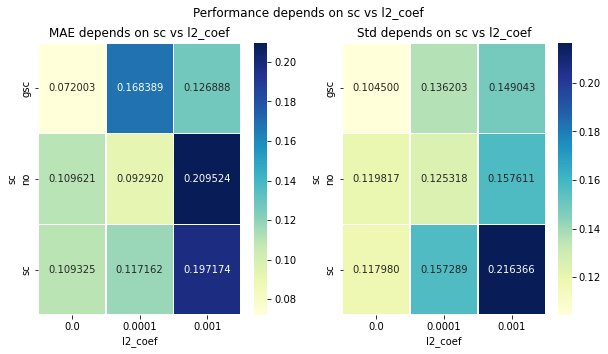

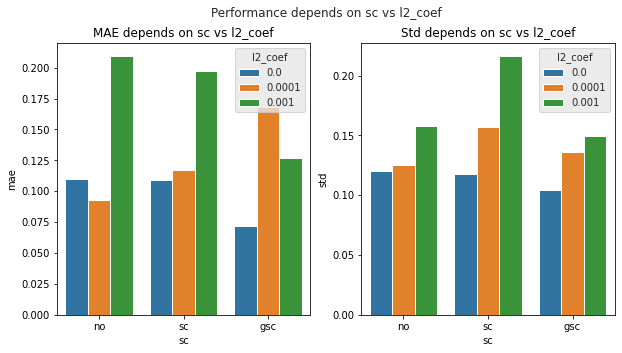

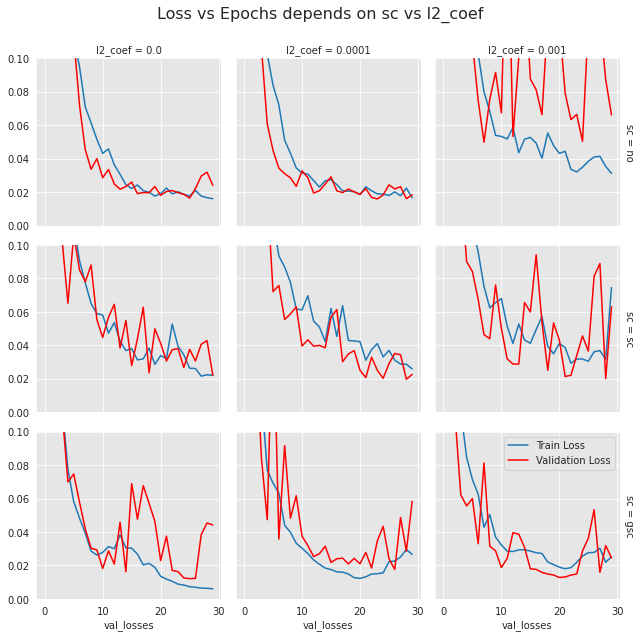

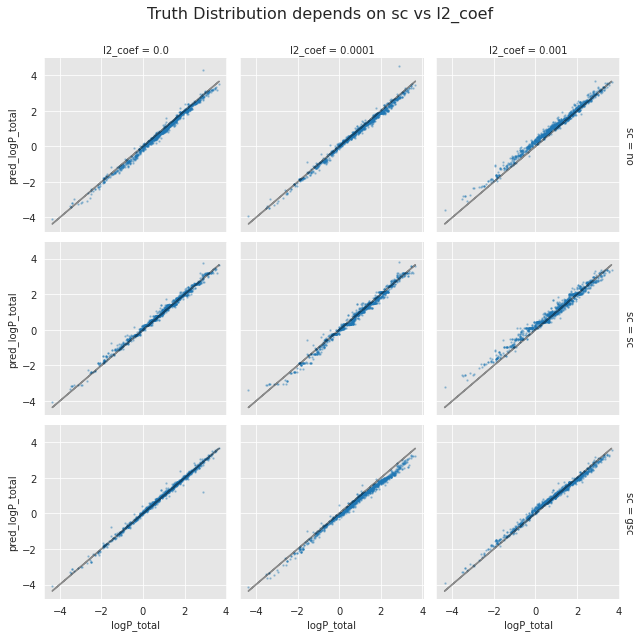

In [35]:
# ------------------------------------------------------------------------------------
df_result = pd.read_json('sc vs l2_coef 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, ylim=0.1)
plot_distribution(df_result, var1, var2)
# ------------------------------------------------------------------------------------